(154, 1600)


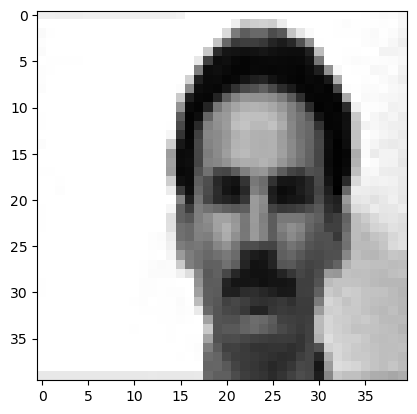

In [1]:
import os, sys
from PIL import Image
import numpy
import matplotlib.pyplot as plt

imgdir = "./yalefaces"

X = []
first = True
for filename in os.listdir(imgdir):
	parts = filename.split('.')
	if parts[1] != 'txt':
		im = Image.open(imgdir + "/" + filename)
		im = im.resize((40,40))
		im = numpy.atleast_2d(numpy.array(im.getdata(),dtype=numpy.float64))
		if len(X) == 0:
			X = im
		else:
			X = numpy.append(X,im,axis=0)

print(X.shape)
plt.imshow(numpy.reshape(X[0],(40,40)),cmap='gray')
plt.show()


##### Take the 154×1600 data matrix and performs PCA using scikit-learn on the data to extract its eigenvectors and eigenvalues.

In [2]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

eigenvectors = pca.components_
eigenvalues = pca.explained_variance_

print(f"Eigenvectors shape: {eigenvectors.shape}")
print(f"Eigenvalues shape: {eigenvalues.shape}")

Eigenvectors shape: (154, 1600)
Eigenvalues shape: (154,)


##### Determine the smallest k such that the k largest eigenvalues constitue at least 95% of the eigenvalues

In [3]:
# this is in values of variance
# do a cum sum of the values since the eigenvalues are order high -> low
# and then just find it when it reaches 95% threshold
total = numpy.sum(eigenvalues)
ratios = eigenvalues / total
cumulative = numpy.cumsum(ratios)

k = numpy.argmax(cumulative >= 0.95) + 1
print(f"k = {k}")
print(f"Cum-Sum: {cumulative[k-1]:.2%}")

k = 32
Cum-Sum: 95.17%


##### Project subject02.centerlight onto the k most important principle components, resulting in a feature vector of length k

In [4]:
filename_to_find = "subject02.centerlight"
idx_of_file = None

idx = 0
for filename in os.listdir(imgdir):
    parts = filename.split('.')
    if parts[1] != 'txt':
        if filename_to_find in filename:
            idx_of_file = idx
            print(f"Found {filename} at index {idx_of_file}")
            break
        idx += 1

if idx_of_file is None:
    print(f"{filename_to_find} not found")

# getting the picture in our data array, making sure to keep the dimension
# that's why I slice it even with len 1
subject_02_centerlight = X[idx_of_file:idx_of_file+1]

# center data and project it onto the top k eigenvectors->transposed
centered_data = subject_02_centerlight - pca.mean_
projection = centered_data @ eigenvectors[:k, :].T

print(f"subject_02_centerlight.shape: {subject_02_centerlight.shape}")
print(f"projeted.shape: {projection.shape}")   

Found subject02.centerlight at index 56
subject_02_centerlight.shape: (1, 1600)
projeted.shape: (1, 32)


#### Reconstruct this person using the k most significant principle components (feature vector should be 1 * 1600), undo standardization

In [5]:
# here, i can reconstruct the face by combining k eigenfaces with their weights, 
# then add mean back from standarizing (k = 1600 dimensions)
reconstructed = projection @ eigenvectors[:k, :] + pca.mean_
print(f"reconstructred.shape: {reconstructed.shape}")

reconstructred.shape: (1, 1600)


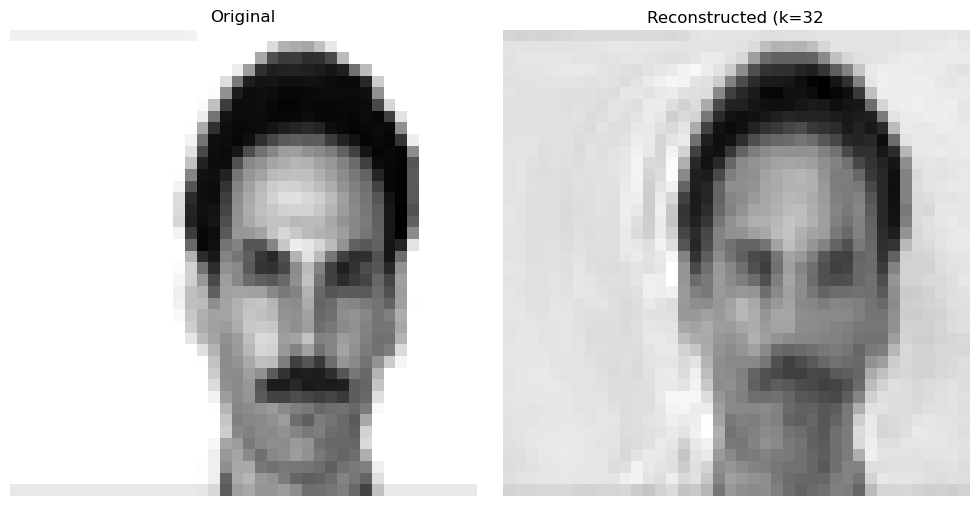


k = 32


In [6]:
original_image = numpy.reshape(subject_02_centerlight, (40, 40))
reconstructed_image = numpy.reshape(reconstructed, (40, 40))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title(f'Reconstructed (k={k}')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"\nk = {k}")